In [26]:
import os
import pickle
import statistics
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from datetime import date, datetime, timedelta

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
%matplotlib notebook

%reload_ext line_profiler

In [410]:
def get_df_day(df_all, day):
    '''Get 2 hours of data just prior to the time given'''
    # return the 2 hours just prior to the datetime (and include the datetime)
    # if there is not data in the 2 hours before, it will get what is there
    prior_2_hrs = day - pd.Timedelta(120,'m')
    return df_all[(df_all.index >= prior_2_hrs) & (df_all.index <= day)]

def find_gaps_from_df(df_all, size_of_gap):
    '''Find the date just before a gap in data of the size given'''
    # fillna(size_of_gap) includes the very last day of use as a day before a gap
    # Would this be faster? :
    # index = df_all.to_series(keep_tz=True)
    # gaps = index.diff(-1).fillna(size_of_gap).abs().ge(size_of_gap)
    # day_before = index[gaps]
    gaps = df_all.index.to_series(keep_tz=True).diff(-1).fillna(size_of_gap).abs().ge(size_of_gap)
    day_before = df_all[gaps]
    return list(day_before.index)

def possible_flatline(df, low_HR_thres, high_HR_thres, low_O2_thres, valid_thres):
    '''Find critical events (high or low heart rate or low oxygen)in the data given'''
#     monitoring_on = any(df.base_state_12)#df.base_state_4.astype(bool) & ~df.base_state_6.astype(bool)#~df.base_state_9.astype(bool) & ~df.base_state_10.astype(bool) & ~df.base_state_12.astype(bool)
    valid_percent = df.valid_count/df['count']
    
    critical_vitals = (df.heart_rate_raw_min < low_HR_thres) | (df.oxygen_raw_min < low_O2_thres) | (df.heart_rate_raw_max > high_HR_thres)
    critical_event = any(critical_vitals & (valid_percent >= valid_thres))
    
#     if critical_event & monitoring_on:
#         return 'Yes, monitoring on'
#     elif critical_event:
#         return 'Yes, not monitoring'
    if critical_event:
        return True
    else:
        return False # Baby vitals look good or 'invalid'
    
def notifications(df):
    '''Return:
        Red/Yellow - if there was a red or yellow notification on last day of use
        None - if there was not'''
    if any(df.base_state_12):
        return 'Red'
    elif any(df.base_state_9) or any(df.base_state_10):
        return 'Yellow'
    else:
        return 'None'
    
def classify_last_use(df):
    '''Return the state of the device in the last 10 minutes of last day of use 
                (battery low, not monitoring, or monitoring)'''
    if df.iloc[-1].battery_level_min < 8:
        return 'Battery low'
    elif (df.base_state_4.astype(bool) & ~df.base_state_6.astype(bool) & ~df.base_state_7.astype(bool)).iloc[-1]:
        return 'Not monitoring'
    else:
        return 'Monitoring on' 


def last_vitals(df):
    # good vitals last 10 min (good if averages are good) should I just look at averages???
    # Maybe instead do this on 2 sec and see how many valid points are outside thresholds? 
        #If its only 1 in 10 minutes then should be fine, unless it's the last one.?
    df = df.loc[df.valid_count > 2]
    if df.shape[0] == 0:
        return 'not valid'
    elif df.shape[0] == 1:
        return classify_10_min(df.iloc[-1])
    
    last_20_min = df.loc[df.valid_count > 0].iloc[-2:]
    
    if (df.iloc[-1].heart_rate_raw_std > 10) or (df.iloc[-1].oxygen_raw_std > 10):
        return 'high variance'
    # Check the last 20 minutes avgs vs last 10 minutes min (critical if either is outside threshold)
    elif (df.iloc[-1].heart_rate_raw_min < 60) or (last_20_min.heart_rate_raw_mean.mean() < 60):
        return 'low HR'
    elif (df.iloc[-1].heart_rate_raw_max > 220) or (last_20_min.heart_rate_raw_mean.mean() > 220):
        return 'high HR'
    elif (df.iloc[-1].oxygen_raw_min < 80) or (last_20_min.oxygen_raw_mean.mean() < 80):
        return 'low O2'
    else:
        return 'Good vitals'

def classify_10_min(last_10_min):
    if (last_10_min.heart_rate_raw_std > 10) or (last_10_min.oxygen_raw_std > 10):
        return 'high variance'
    
    #Check the last 20 minutes avgs vs last 10 minutes min (critical if either is outside threshold)
    elif (last_10_min.heart_rate_raw_min < 60):
        return 'low HR'
    elif (last_10_min.heart_rate_raw_max > 220):
        return 'high HR'
    elif (last_10_min.oxygen_raw_min < 80):
        return 'low O2'
    else:
        return 'Good vitals'
    
def sock_off(df):
    '''Did the sock get taken off on last day of use with good vitals just before?'''
    # Was there a big change in temp
    df['diff_1'] = df.skin_temperature_max - df.skin_temperature_min
    
    # Did the temperature go up or down after a big change in temp
    df['diff_next'] = df.skin_temperature_min.diff(-1).fillna(1)
    
    df = df.loc[(df.diff_1 >= 10) & (df.diff_1 <= 35) & (df.diff_next > 0),:]
    
    # Was there a signal at least half of the previous 10 min
#     df['valid_prev'] = (df['valid_count']/df['count']).shift(1).fillna(1)
#     df = df[df.valid_prev >= .5]
    
#     df['bad_vitals'] = ((df_critical.oxygen_raw_min < 80) | (df_critical.heart_rate_raw_min < 60) | (df_critical.heart_rate_raw_min > 220)).shift(1).fillna(False)
    
    if df.shape[0] == 0:
        return False#"sock not taken off"
#     elif df.iloc[0].bad_vitals:
#         return "sock off + bad vitals"
    else:
        return True#"sock off + good vitals"
    
    
# def clean2(df):
#     '''Get rid of data before there are 24 hours of base state 7'''
# #     df = df[(df.index > '2016-01-01 23:59:59') | (df.index < '2016-01-01 00:00:00')]
#     # This may get rid of high risk babies/babies with conditions..
#     base_7 = df.base_state_7.cumsum()
#     mask = base_7 >= 144 
#     return df.loc[mask]

def at_risk(df):
    '''is there at least 24 hours of base 7 data
        If not this could be bad hardware or a baby that has a preexisting condition'''
    base_7 = df.base_state_7.cumsum()
    mask = base_7 >= 144 
    if df.loc[mask].shape[0] == 0:
        return True
    else:
        return False

# def low_baseline(df):
#     '''Give at risk flag to users who have low saturation during the first few uses'''
#     return df.iloc[:144].oxygen_raw_mean.mean() < 90

# def day_of_monitoring(dsn, date):
#     df_3 = pickle.load(open(f'16000_dfs/{dsn}_df.p', 'rb'))
#     df_3 = df_3.resample('D').mean().dropna()
#     help_ = df_3[df_3.index < f'{date} 00:00:00']
#     return help_.shape[0]+1

def had_cc(dsn, cc_dsns):
    if dsn in cc_dsns:
        return 1
    else:
        return 0
    
# def signal_loss(df_day):
#     valid_percent = df_day.valid_count/df_day['count']
#     ten_percent = valid_percent[valid_percent > .1]
#     if ten_percent.shape[0] == 0:# Need to know if valid_percent <= .1 == 0
#         return 'None'
#     else:
#         return valid_percent[valid_percent > .1].index[-1] + timedelta(minutes=10)
    
def in_US(dsn, day, location_df):
    # TODO: is df sorted?
    location = location_df.loc[location_df.created_at <= str(day)]
    if location.shape[0] == 0:
        return False
    else:
        return True
    
def baby_age(dsn, day, reg_baby_df):
    # TODO: is df sorted?
    info = reg_baby_df.loc[(reg_baby_df.registered_at <= str(day))]
    birthdays = info[info.birthdate != '']
    if birthdays.shape[0] == 0:
        return pd.Timedelta(days=-1) 
    else:
        bday = birthdays.birthdate.values[-1]
        return day.date() - date(int(bday[:4]), int(bday[4:6]), int(bday[6:]))# diff between birthday and day of incident

## Functions for sock off and signal loss

In [455]:
with open("column_names.txt") as f:
    column_names = f.readlines()
column_names = column_names[0].split(',')

def load_2sec(dsn, day, time_index=False):
    # Load 2 sec data
    df_2sec = pd.read_csv(f'16000_2sec/{day}/{dsn}.csv.zip', names=column_names)
    df_2sec.timestamp = pd.to_datetime(df_2sec.timestamp, unit='s')
    df_2sec = df_2sec.sort_values(by=['timestamp'])
    df_2sec.drop_duplicates('timestamp',inplace=True)

    # Think about what this does
    df_2sec = df_2sec.loc[(df_2sec.base_state > 3) & (df_2sec.ble_rssi != 0) & (df_2sec.heart_rate_raw >0)]
    
    df_2sec.reset_index(inplace=True, drop=True)
    
    if time_index:
        df_2sec.set_index('timestamp',inplace=True)
    
    return df_2sec

def lost_signal(df):
    consecutive_valid = df.notification_mask.eq(0).rolling(window=16).sum().fillna(0)
    if consecutive_valid[consecutive_valid>=15].shape[0] == 0:
        return 0
    return consecutive_valid[consecutive_valid>=15].index[-1]

def multiple_sock_off(df, thresh=-.05):
    diff_new = df.skin_temperature.diff().fillna(0)
    diff_rolling = diff_new.rolling(300).mean().fillna(method='bfill') # different window?
    off_indices = []
    
    # find ALL indices of min..
    if min(diff_rolling) <= thresh:
        less_than = diff_rolling[diff_rolling < thresh]
        drop_indices = [0] + list(np.where(np.diff(less_than.index.values) > 30)[0] + 1)
        drop_indices = less_than.index.values[drop_indices]
        
        # For each index:
        for i in drop_indices:
            if i == 0:
                off_indices.append(0)
            else:
                off = diff_new.iloc[max(0,(i-275)):i]
                off = off.loc[off != 0]
                off_index_reset = off.eq(-1).reset_index().skin_temperature.rolling(window=4).sum().fillna(0).idxmax() - 3
                count_neg_1 = off.iloc[off_index_reset:].eq(-1).value_counts()

                #  if there are no False or no True:
                if len(count_neg_1) == 1:
                    if count_neg_1.index[0]:
                        off_index = off.index[off_index_reset]
                        off_indices.append(off_index)
                elif count_neg_1[True]/(count_neg_1[False] + count_neg_1[True]) >= .7: # What threshhold?
                    off_index = off.index[off_index_reset] # This is the index where the sock came off
                    off_indices.append(off_index)
            
    return off_indices

In [4]:
# df_critical.loc[df_critical.valid_count > 0].iloc[-2:].heart_rate_raw_mean.mean()

In [426]:
def find_critical_events(dsn_list, location_data, baby_info, size_of_gap=pd.Timedelta(21,'D'), low_HR_thres=60, high_HR_thres=220, O2_thres=80, valid_thres=.3):
    '''Find all last use cases and classify critical events'''
    classifications = []
    cc_dsns = pickle.load(open('cc_dsns.p', 'rb')) # dsns with connected care
    for dsn in tqdm_notebook(dsn_list):
        df_all = pickle.load(open(f'16000_dfs/{dsn}_df.p', 'rb')) # is this sorted/have duplicate timestamps been dropped?
        at_risk_or_hardware = at_risk(df_all) # TODO may need to do this for each gap (if theres a gap in the first few days of use..)
        valid_df = df_all.loc[df_all.valid_count > 0]
        dsn_location = location_data.loc[location_data.dsn == dsn]
        dsn_baby_info = reg_baby_info.loc[reg_baby_info.dsn == dsn]
        
        # df could be empty! if so, skip it
        if valid_df.shape[0] != 0: 
            gaps = find_gaps_from_df(valid_df, size_of_gap)
            if dsn in cc_dsns:
                cc = 1
            else:
                cc = 0
            for day in gaps:
                # Maybe calculate age of baby and dont add a row if they are older than 1
                age = baby_age(dsn, day, dsn_baby_info)
                if (age < pd.Timedelta(days=365)) and (age >= pd.Timedelta(days=0)):
                    
                    # if day is w/in 2 weeks of when Tanner did the rollups - disregard. I got the data Jan 30 or 31
                    if (str(day) <= '2019-01-17 00:00:00') & (str(day) >= '2017-01-01 00:00:00'):
                        # Check if in the US
                        if in_US(dsn, day, dsn_location):
                            df_day = get_df_day(valid_df, day)
                            flatline = possible_flatline(df_day, low_HR_thres, high_HR_thres, O2_thres, valid_thres)
                            vitals = last_vitals(df_day)
                            classifications.append((dsn, day.date(), flatline, vitals, cc, at_risk_or_hardware, age))
            
    return classifications


In [94]:
# If the user doesn't have registration data, don't worry about them; RIGHT NOW I DON'T HAVE ALL REGISTRATION DATA!
my_list1 = pickle.load(open("rollups_dsns.p", "rb"))
registration_list = pd.read_csv("/Users/brodriguez/Documents/parsed_registration_pre_20190113.csv", compression='gzip').dsn.values
baby_info = pd.read_csv('/Users/brodriguez/Documents/parsed_datapoint_pre_20190113.csv', compression='gzip', index_col=0).dsn.values
valid_dsns = pickle.load(open('valid_dsns.p', 'rb')) # non empty and registered if start of use is after feb 22 2017
my_list = list(set(my_list1).intersection(valid_dsns))
post_feb_dsns = list(set(my_list1).intersection(set(valid_dsns).intersection(set(registration_list).intersection(baby_info))))

In [89]:
new_dsns_with_base_5 = []
states = ['base_state_4', 'base_state_6', 'base_state_7', 
              'base_state_8', 'base_state_9', 'base_state_10', 
              'base_state_12']
# for dsn in tqdm_notebook(my_list1):
#     df_all = pickle.load(open(f'16000_dfs/{dsn}_df.p', 'rb'))
#     df_all = df_all.loc[df_all.valid_count > 0]
#     if df_all.shape[0] != 0:
#         no_base = ~df_all[states].apply(any, 1) #This is true if one of the states is true, false if none of them are true
#         if any(no_base):
#             new_dsns_with_base_5.append(dsn)
            

In [39]:
len(new_dsns_with_base_5)

2084

In [40]:
# pickle.dump(new_dsns_with_base_5, open('16000_dsns_with_base5.p', "wb"))

In [47]:
# count = 0
# dsns_post_2016 = []
# for dsn in tqdm_notebook(my_list):
#     df_all = pickle.load(open(f'16000_dfs/{dsn}_df.p', 'rb'))
#     if str(df_all.index[0]) > '2017-01-01':
# #         count+=1
#         dsns_post_2016.append(dsn)
# #     print(df_all.index[0], dsn)
# print(len(dsns_post_2016))
# DOESNT MAKE SENSE because the dsn corresponds to base station..a new sock could have been connected..


8867


In [374]:
# How many of the 16000 had cc?
# cc_dsns = pickle.load(open('cc_dsns.p', 'rb'))
len(cc_dsns.intersection(my_list1))

5001

In [9]:
test_gaps = find_gaps_from_df(pickle.load(open(f'16000_dfs/AC000W000449153_df.p', 'rb')), pd.Timedelta(21,'D'))

In [278]:
# for gap in test_gaps:
#     print(str(gap.date()))

In [117]:
%lprun -f find_critical_events find_critical_events(my_list[:15], location_data)

### Run flatline/last use algorithm

In [191]:
# location_data = pd.read_csv('/Users/brodriguez/Documents/GPS_locations.csv', compression='gzip', index_col=0)
location_data = location_data.loc[location_data.cc == 'US'].sort_values(by='created_at')

reg_baby_info = pickle.load(open('reg_baby_data_test.p', 'rb')).sort_values(by='registered_at')

In [427]:
# Every ** dropped below 70, noncriticals don't keep dropping
classes = find_critical_events(post_feb_dsns, location_data, reg_baby_info, O2_thres=70, valid_thres=.4) 
column_names = ['dsn', 'date', 'critical_event', 'last_10_minutes', 'cc', 'at_risk_or_issues', 'baby_age']
df_classified = pd.DataFrame(classes, columns=column_names)

In [496]:
# df_classified.dsn.value_counts()

In [505]:
# TODO: take df_classified where there was a critical event and get 
    # the times for sock off and signal loss to further classify
    
# Apply function by row that uses dsn and date? axis = 1
def f(x):
    # try except for files I need to get??
    try:
        df = load_2sec(x['dsn'], str(x['date']).replace('-',''))#? or index 0, 1?
    except FileNotFoundError:
        return 'Need data'
    time_values = df.timestamp
    last_reading = df.loc[df.base_state > 3].timestamp.values[-1]
    loss = lost_signal(df)
    sock = multiple_sock_off(df) 
    # if lost signal is within 1 min of last reading (before charging) return 'data cut off' 
    if abs(time_values[loss] - last_reading) < pd.Timedelta(minutes=1):
        return 'data cut off'
    # if sock comes of w/in ~5 min (maybe less) of lost signal return 'sock off'
    elif len(sock) > 0: 
        for sock_off in sock:
            # TODO or if signal was lost due to movement..
            if abs(time_values[sock_off] - time_values[loss]) <= pd.Timedelta(minutes=5):
                return 'sock off' 
    # TODO if signal was lost due to movement return data cut off
    return 'signal lost before sock off'

#dont want to apply this to whole df, just to critical events (have to get 2sec data on computer before)
df_critical = df_classified.loc[df_classified.critical_event == True]
df_critical['signal_sock'] = df_critical.apply(f, axis=1)

# df_test = df_classified.loc[(df_classified.dsn == 'AC000W001042034') & (df_classified.critical_event == True)]
# df_test['signal_sock'] = df_test.apply(f,axis=1)
# df_test

/Users/brodriguez/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [513]:
# ** cases
df_critical[(df_critical.last_10_minutes != 'high variance') &
            (df_critical.last_10_minutes != 'Good vitals') &
            (df_critical.last_10_minutes != 'not valid') &
            (df_critical.at_risk_or_issues == False) &
            (df_critical.signal_sock != 'sock off') & 
            (df_critical.signal_sock != 'Need data')]

,dsn,date,critical_event,last_10_minutes,cc,at_risk_or_issues,baby_age,signal_sock
180,AC000W001178851,2017-04-17,True,low O2,1,False,40 days,signal lost before sock off
1920,AC000W003423133,2018-09-17,True,low O2,0,False,103 days,signal lost before sock off
1937,AC000W002581981,2018-10-02,True,low O2,0,False,36 days,signal lost before sock off
2035,AC000W002431296,2018-10-06,True,low O2,1,False,271 days,data cut off
2137,AC000W001042034,2017-12-24,True,low O2,0,False,109 days,signal lost before sock off
2325,AC000W001045040,2018-04-10,True,low O2,0,False,350 days,signal lost before sock off
2797,AC000W001129337,2017-08-04,True,low O2,0,False,288 days,signal lost before sock off
3062,AC000W001152749,2018-09-30,True,low O2,1,False,220 days,signal lost before sock off
4015,AC000W000238296,2018-01-08,True,low O2,0,False,205 days,signal lost before sock off
4114,AC000W000420436,2017-03-21,True,low O2,1,False,8 days,signal lost before sock off


In [520]:
# * cases
df_critical[(df_critical.last_10_minutes != 'Good vitals') &
            (df_critical.last_10_minutes != 'not valid') & 
            (df_critical.at_risk_or_issues == False) & 
            (((df_critical.last_10_minutes != 'high variance') & (df_critical.signal_sock == 'sock off')) | 
            ((df_critical.last_10_minutes == 'high variance') & (df_critical.signal_sock == 'signal lost before sock off')))]

,dsn,date,critical_event,last_10_minutes,cc,at_risk_or_issues,baby_age,signal_sock
131,AC000W000444906,2018-08-18,True,low O2,0,False,3 days,sock off
394,AC000W002446952,2018-09-21,True,low O2,0,False,106 days,sock off
597,AC000W001157578,2018-07-01,True,high variance,0,False,158 days,signal lost before sock off
644,AC000W000661765,2017-09-08,True,low O2,0,False,133 days,sock off
718,AC000W001118182,2018-07-15,True,high HR,1,False,311 days,sock off
1464,AC000W001182156,2018-04-03,True,low O2,1,False,340 days,sock off
2260,AC000W001082216,2017-03-11,True,low O2,1,False,4 days,sock off
2362,AC000W001179577,2017-05-06,True,low O2,1,False,6 days,sock off
2519,AC000W000652347,2018-07-04,True,low O2,0,False,13 days,sock off
2608,AC000W000327765,2018-06-22,True,high variance,1,False,134 days,signal lost before sock off


In [522]:
# ? cases
df_critical[(df_critical.signal_sock != 'Need data') & 
            (df_critical.last_10_minutes != 'not valid') & 
            ((df_critical.at_risk_or_issues == True) | 
            ((df_critical.last_10_minutes == 'high variance') & (df_critical.signal_sock != 'signal lost before sock off')) |
            ((df_critical.last_10_minutes == 'Good vitals') & (df_critical.signal_sock == 'signal lost before sock off')))]

,dsn,date,critical_event,last_10_minutes,cc,at_risk_or_issues,baby_age,signal_sock
285,AC000W001217119,2018-10-04,True,high variance,0,False,147 days,sock off
469,AC000W001121424,2017-03-25,True,high variance,0,False,6 days,sock off
880,AC000W001096216,2017-09-23,True,high variance,0,True,6 days,sock off
1748,AC000W000655511,2017-03-17,True,low O2,0,True,5 days,sock off
1875,AC000W003382303,2018-05-08,True,Good vitals,0,False,333 days,signal lost before sock off
1931,AC000W001084878,2017-05-24,True,high variance,0,False,6 days,sock off
2773,AC000W001055680,2017-10-13,True,low O2,0,True,8 days,sock off
3774,AC000W000329183,2018-02-15,True,low O2,0,True,3 days,signal lost before sock off
4198,AC000W002502642,2018-07-21,True,low O2,0,True,72 days,signal lost before sock off
4221,AC000W002629562,2018-09-20,True,high variance,0,True,14 days,signal lost before sock off


In [523]:
# unknown/need data cases
df_critical[df_critical.signal_sock == 'Need data']

,dsn,date,critical_event,last_10_minutes,cc,at_risk_or_issues,baby_age,signal_sock
27,AC000W002444776,2018-01-21,True,Good vitals,0,False,6 days,Need data
84,AC000W001106338,2017-09-02,True,Good vitals,1,False,5 days,Need data
229,AC000W001136334,2018-10-06,True,Good vitals,0,False,269 days,Need data
306,AC000W000366562,2017-12-12,True,Good vitals,1,True,4 days,Need data
338,AC000W001136332,2018-03-12,True,Good vitals,1,False,364 days,Need data
461,AC000W001123882,2018-04-26,True,Good vitals,0,False,343 days,Need data
474,AC000W001206391,2018-09-26,True,Good vitals,0,False,126 days,Need data
504,AC000W001053625,2018-06-10,True,Good vitals,1,False,5 days,Need data
640,AC000W000454619,2017-09-07,True,Good vitals,0,True,24 days,Need data
653,AC000W001072278,2018-07-30,True,Good vitals,0,False,160 days,Need data


In [547]:
df_critical[df_critical.dsn == 'AC000W001050870']

,dsn,date,critical_event,last_10_minutes,cc,at_risk_or_issues,baby_age,signal_sock
11753,AC000W001050870,2017-08-21,True,high variance,0,False,44 days,signal lost before sock off


In [512]:
df_critical[df_critical.dsn == 'AC000W001117360']#.dsn.value_counts()

,dsn,date,critical_event,last_10_minutes,cc,at_risk_or_issues,baby_age,signal_sock
5128,AC000W001117360,2018-03-30,True,high variance,1,False,174 days,signal lost before sock off


In [538]:
df_classified.loc[(df_classified.dsn == 'AC000W002428238')]

,dsn,date,critical_event,last_10_minutes,cc,at_risk_or_issues,baby_age
636,AC000W002428238,2018-06-21,False,Good vitals,0,False,27 days
637,AC000W002428238,2018-10-06,False,Good vitals,0,False,134 days


In [187]:
# df_classified[(df_classified.critical_event != 'No') & (df_classified.last_10_minutes == 'Good vitals')]

In [417]:
df_classified[(df_classified.critical_event != 'No') & 
              (df_classified.last_10_minutes != 'Good vitals') & 
              (df_classified.at_risk_or_issues == False) & 
              (df_classified.last_10_minutes != 'high variance') &
              (df_classified.last_10_minutes != 'not valid')]

,dsn,date,critical_event,last_10_minutes,cc,at_risk_or_issues,baby_age
47,AC000W001101470,2017-06-08,False,low O2,1,False,36 days
141,AC000W001125758,2018-01-21,False,low O2,1,False,10 days
169,AC000W003382949,2018-10-06,False,low O2,1,False,96 days
180,AC000W000444906,2018-08-18,True,low O2,0,False,3 days
185,AC000W001183834,2017-10-19,False,low O2,0,False,4 days
245,AC000W001178851,2017-04-17,True,low O2,1,False,40 days
455,AC000W000336333,2017-08-10,False,low O2,0,False,195 days
468,AC000W000655311,2018-02-25,False,low O2,0,False,-1 days
511,AC000W002446952,2018-09-21,True,low O2,0,False,106 days
536,AC000W002601377,2018-10-06,False,low HR,1,False,51 days


In [403]:
df_classified[(df_classified.critical_event != 'No') &
              (df_classified.at_risk_or_issues == True) & 
              (df_classified.baby_age < pd.Timedelta(days=365)) & 
              (df_classified.baby_age > pd.Timedelta(days=0))]

,dsn,date,critical_event,last_10_minutes,cc,at_risk_or_issues,baby_age
36,AC000W002444776,2018-01-21,"Yes, not monitoring",Good vitals,0,True,6 days
406,AC000W000366562,2017-12-12,"Yes, monitoring on",Good vitals,1,True,4 days
1110,AC000W001096216,2017-09-23,"Yes, not monitoring",high variance,0,True,6 days
1310,AC000W000421078,2017-06-05,"Yes, not monitoring",low O2,1,True,273 days
1311,AC000W000421078,2017-08-15,"Yes, monitoring on",low O2,1,True,344 days
1925,AC000W001215864,2018-03-15,"Yes, monitoring on",low O2,0,True,23 days
1970,AC000W001103489,2017-08-30,"Yes, not monitoring",Good vitals,0,True,72 days
2220,AC000W000655511,2017-03-17,"Yes, not monitoring",low O2,0,True,5 days
2455,AC000W001084878,2017-05-24,"Yes, not monitoring",high variance,0,True,6 days
2803,AC000W001042069,2017-03-12,"Yes, not monitoring",Good vitals,0,True,41 days


In [303]:
help_ = df_classified[(df_classified.critical_event != 'No') & (df_classified.last_10_minutes != 'Good vitals') & (df_classified.at_risk_or_issues == False) & (df_classified.baby_age < pd.Timedelta(days=365)) & (df_classified.baby_age > pd.Timedelta(days=0))]# & (df_classified['sock_off'] == 'sock off + bad vitals')]
for i in range(help_.shape[0]):
    if help_.dsn.values[i] not in critical_dsns:
        print(help_.dsn.values[i], str(help_.date.values[i]).replace('-',''))


AC000W000444906 20180818
AC000W001178851 20170417
AC000W001217119 20181004
AC000W001121424 20170325
AC000W001157578 20180701
AC000W001182156 20180403
AC000W003382303 20180508
AC000W003423133 20180917
AC000W002581981 20181002
AC000W002431296 20181006
AC000W000652347 20180704
AC000W000327765 20180622
AC000W000327765 20180813
AC000W000097127 20180423
AC000W001129337 20170804
AC000W001152749 20180930
AC000W001064992 20180325
AC000W002458905 20180818
AC000W001125189 20170406
AC000W000329183 20180215
AC000W001127414 20170815
AC000W000238296 20180108
AC000W001051206 20180306
AC000W000420436 20170321
AC000W002629562 20180920
AC000W001106323 20171129
AC000W002629595 20180821
AC000W001157432 20180226
AC000W001142861 20171102
AC000W001117360 20180330
AC000W002425361 20180511
AC000W001181229 20180905
AC000W001054070 20171201
AC000W001110992 20180818
AC000W000664530 20180612
AC000W001124036 20170316
AC000W001098007 20170513
AC000W001095742 20180319
AC000W001150990 20180902
AC000W002498325 20181006


In [53]:
critical_dsns = ['AC000W002678759','AC000W001118182','AC000W002430601','AC000W000419427','AC000W000452659','AC000W002430609','AC000W000414548','AC000W000098019','AC000W000340943','AC000W000365980','AC000W000461567','AC000W000260438','AC000W000339980','AC000W000446448','AC000W002428238','AC000W001086996','AC000W000103039','AC000W000366042','AC000W002431571','AC000W001042034','AC000W002580017','AC000W002502642','AC000W000670414','AC000W001204540','AC000W001184353','AC000W000503700','AC000W000672962','AC000W000398460','AC000W000661143','AC000W002577819','AC000W000236258','AC000W001050870','AC000W000253971','AC000W001132677','AC000W000257571','AC000W001058876','AC000W000021330','AC000W000021330','AC000W001211941','AC000W002578613','AC000W001212809','AC000W000658842','AC000W001052578','AC000W000365980','AC000W001045532','AC000W000668914','AC000W000341549','AC000W000336510','AC000W000337099','AC000W000339336','AC000W000421705','AC000W001179577','AC000W000330907','AC000W000655511','AC000W001058273','AC000W001092503','AC000W001096216','AC000W000422937','AC000W002446952','AC000W000671067','AC000W000504597','AC000W001123677','AC000W001056677','AC000W000332422','AC000W001040321','AC000W001071988','AC000W001203612','AC000W001055680','AC000W001084878','AC000W000418343','AC000W000661800','AC000W000423996','AC000W002428977','AC000W001045040','AC000W001082216','AC000W000462074','AC000W000417819','AC000W001122268','AC000W001136285','AC000W001141068','AC000W001183543','AC000W000397544','AC000W000661765','AC000W000443281','AC000W000400671','AC000W001085332','AC000W000444730']
expected_critical = ['AC000W002678759','AC000W001118182','AC000W002430601','AC000W000452659','AC000W002430609','AC000W000098019','AC000W000340943','AC000W000365980','AC000W000260438','AC000W000339980','AC000W000446448']
critical_dsns = list(set(critical_dsns))


In [194]:
set(df_classified[(df_classified.critical_event != 'No') & (df_classified.last_10_minutes != 'Good vitals') & (df_classified.at_risk_or_issues == True) & (df_classified.baby_age < pd.Timedelta(days=365))].dsn.values).intersection(critical_dsns)


{'AC000W000655511',
 'AC000W000670414',
 'AC000W001045532',
 'AC000W001055680',
 'AC000W001084878',
 'AC000W001096216',
 'AC000W001179577',
 'AC000W001212809',
 'AC000W002502642'}

In [392]:
df_classified[(df_classified.dsn == 'AC000W000097127') & (df_classified.baby_age < pd.Timedelta(days=365))]

,dsn,date,critical_event,last_10_minutes,cc,at_risk_or_issues,baby_age
3436,AC000W000097127,2018-04-23,"Yes, not monitoring",high variance,0,False,149 days
3437,AC000W000097127,2018-05-24,"Yes, not monitoring",Good vitals,0,False,20 days


In [61]:
# set(critical_dsns).intersection(dsns_post_2016)

### Analysis on critical events

In [542]:
df_test = pickle.load(open(f'16000_dfs/AC000W000670414_df.p', 'rb'))

In [160]:
# df_test[df_test.index > '2018-01-24 00:00:00']#.oxygen_raw_min

In [545]:
df_test[(df_test.index < '2018-02-12 00:00:00')].base_state_7.sum()#.oxygen_avg_min

94.0

In [385]:
# Is baby at risk (i.e., do the first 24 hours of monitoring show low oxygen saturation?)
df_test.iloc[:144].oxygen_raw_mean.mean() < 90

False

In [96]:
# only look at data after a user has had 24 hours of base state 7 if that's what we want to do 
f = df_test.base_state_7.cumsum()
mask = f >= 144 
df_test[mask] #if empty discard data

,dsn,count,valid_count,movement_raw_mean,movement_raw_min,movement_raw_max,movement_raw_std,skin_temperature_mean,skin_temperature_min,skin_temperature_max,...,oxygen_raw_min,oxygen_raw_max,oxygen_raw_std,base_state_4,base_state_6,base_state_7,base_state_8,base_state_9,base_state_10,base_state_12
timestamp,,,,,,,,,,,,,,,,,,,,,


In [467]:
with open("column_names.txt") as f:
    column_names = f.readlines()
column_names = column_names[0].split(',')

In [468]:
df = pd.read_csv('16000_2sec/20180728/AC000W002580017.csv.zip', names=column_names)

In [474]:
df.heart_rate_raw.value_counts()

0      32810
120    10650
Name: heart_rate_raw, dtype: int64

### Last 10 minutes (gaps 3 weeks or longer)

In [ ]:
df_classified.last_10_minutes.value_counts()

In [ ]:
11458/df_classified.shape[0]

### Distribution of valid_count for 100 dsns

In [333]:
df_all_list = [pickle.load(open(f'16000_dfs/{dsn}_df.p', 'rb')) for dsn in list(my_list)[0:1000]]

In [334]:
df_all = pd.concat(df_all_list)

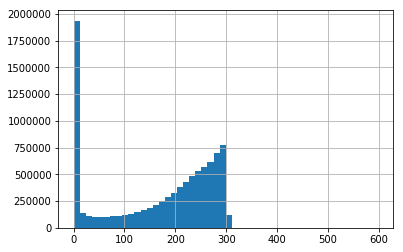

In [335]:
df_all.valid_count.hist(bins=50)

In [336]:
df_all[df_all.oxygen_raw_std >= 5]

,dsn,count,valid_count,movement_raw_mean,movement_raw_min,movement_raw_max,movement_raw_std,skin_temperature_mean,skin_temperature_min,skin_temperature_max,...,oxygen_raw_min,oxygen_raw_max,oxygen_raw_std,base_state_4,base_state_6,base_state_7,base_state_8,base_state_9,base_state_10,base_state_12
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-11-04 09:30:00+00:00,AC000W000444533,288,3.0,30.500000,0.0,216.0,39.280107,169.045139,166.0,171.0,...,79.0,95.0,8.082904,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2016-11-07 11:00:00+00:00,AC000W000444533,299,180.0,9.819398,0.0,56.0,4.834248,177.000000,177.0,177.0,...,49.0,100.0,8.263401,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2016-11-17 12:40:00+00:00,AC000W000444533,285,176.0,10.677193,0.0,184.0,18.702103,176.529825,174.0,179.0,...,83.0,102.0,5.912146,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2016-11-21 11:20:00+00:00,AC000W000444533,298,42.0,23.208054,1.0,233.0,26.162603,170.221477,167.0,172.0,...,75.0,102.0,5.501610,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2016-11-28 08:40:00+00:00,AC000W000444533,299,5.0,14.180602,3.0,99.0,12.574376,166.040134,165.0,167.0,...,62.0,100.0,15.565989,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-11-29 09:00:00+00:00,AC000W000444533,299,83.0,19.230769,0.0,144.0,26.649293,168.317726,167.0,171.0,...,82.0,101.0,6.066993,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2016-11-29 14:10:00+00:00,AC000W000444533,298,50.0,31.989933,0.0,215.0,37.382947,179.832215,175.0,183.0,...,85.0,99.0,5.067866,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2016-12-02 12:10:00+00:00,AC000W000444533,295,80.0,13.850847,0.0,149.0,19.969146,157.450847,151.0,161.0,...,63.0,99.0,9.321601,1.0,1.0,1.0,0.0,0.0,0.0,1.0
2016-12-02 12:30:00+00:00,AC000W000444533,286,22.0,16.251748,4.0,60.0,11.061848,162.755245,162.0,164.0,...,80.0,101.0,6.486249,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
df_all

In [ ]:
df_all.valid_count.mean()

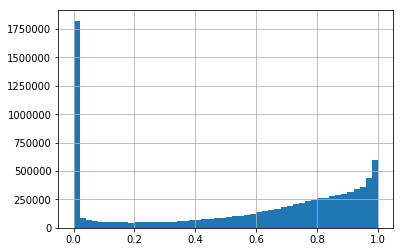

In [337]:
(df_all.valid_count / df_all['count']).hist(bins=50)

### Stats on the 16000

In [174]:
days_used = []
for dsn in tqdm_notebook(my_list):
    df_all = pickle.load(open(f'16000_dfs/{dsn}_df.p', 'rb'))
    df_all = df_all.resample('D').mean().dropna()
#     days_used.append(df_all.shape[0])
    if df_all.shape[0] > 600:
        days_used.append(dsn)

In [175]:
len(days_used)

8

In [176]:
days_used

['AC000W000341930',
 'AC000W000237416',
 'AC000W000449506',
 'AC000W000332343',
 'AC000W000331837',
 'AC000W000339260',
 'AC000W000020695',
 'AC000W000330742']

In [12]:
day_counts = {day.date():0 for day in pd.date_range('20150101', '20190131')}
for dsn in tqdm_notebook(my_list):
    df_all = pickle.load(open(f'16000_dfs/{dsn}_df.p', 'rb'))
    df_all = df_all.resample('D').mean().dropna()
    if df_all.shape[0] != 0:
        for day in df_all.index:
            day_counts[day.date()] += 1

<IPython.core.display.Javascript object>


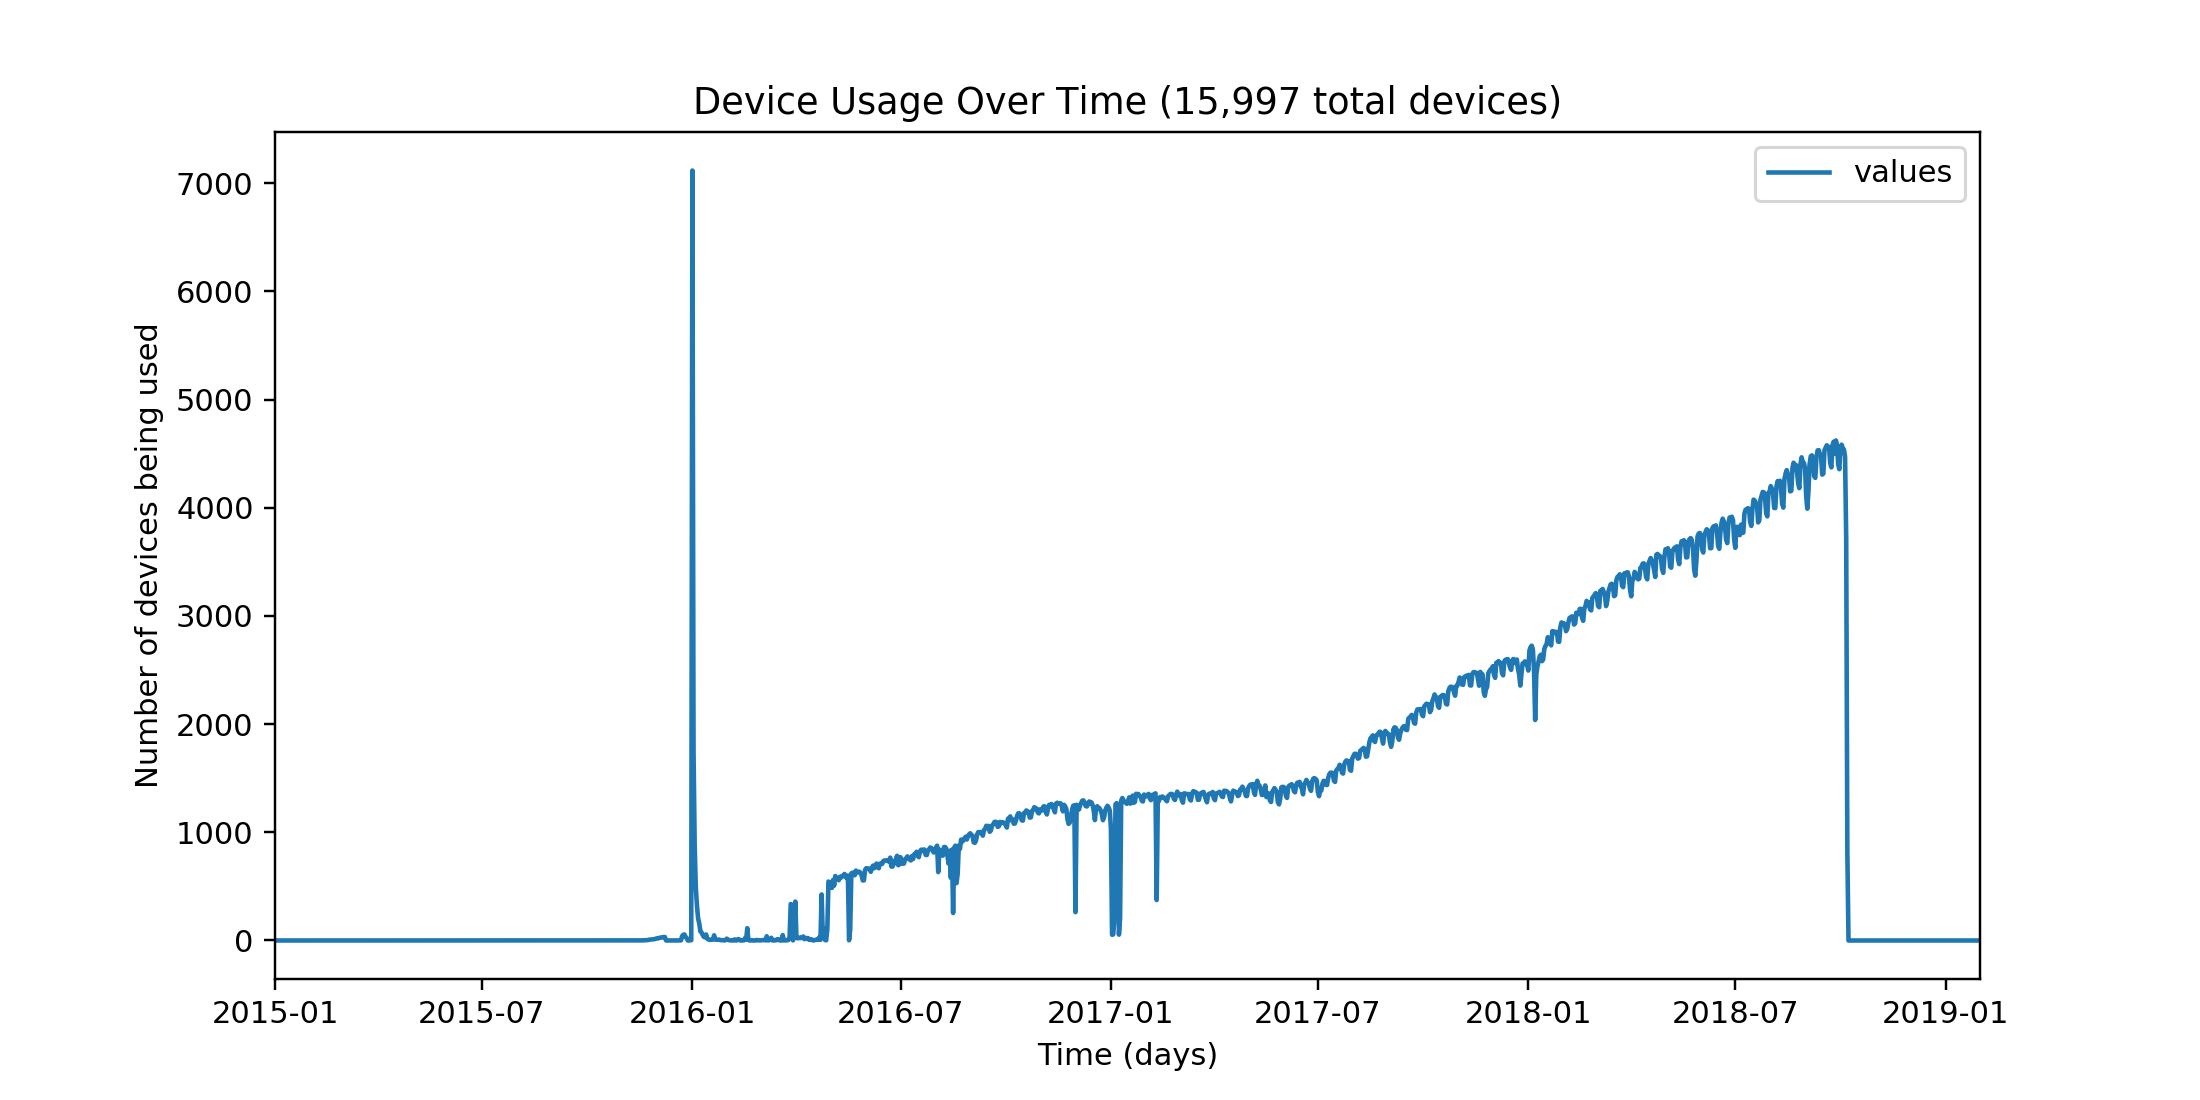

Text(0.5, 1.0, 'Device Usage Over Time (15,997 total devices)')

In [13]:
df = pd.DataFrame.from_dict(day_counts, orient='index', columns=['values'])
df.sort_index(inplace=True)
df.plot()
plt.xlabel("Time (days)")
plt.ylabel("Number of devices being used")
plt.title("Device Usage Over Time (15,997 total devices)")

In [205]:
df_2 = pickle.load(open(f'16000_dfs/AC000W000021330_df.p', 'rb'))
count_days = {day.date():0 for day in pd.date_range(df_2.index.min().date()-pd.Timedelta(days=10), df_2.index.max().date()+pd.Timedelta(days=10))}
df_2 = df_2.resample('D').mean().dropna()
if df_2.shape[0] != 0:
    for day in df_2.index:
        count_days[day.date()] = 1

<IPython.core.display.Javascript object>


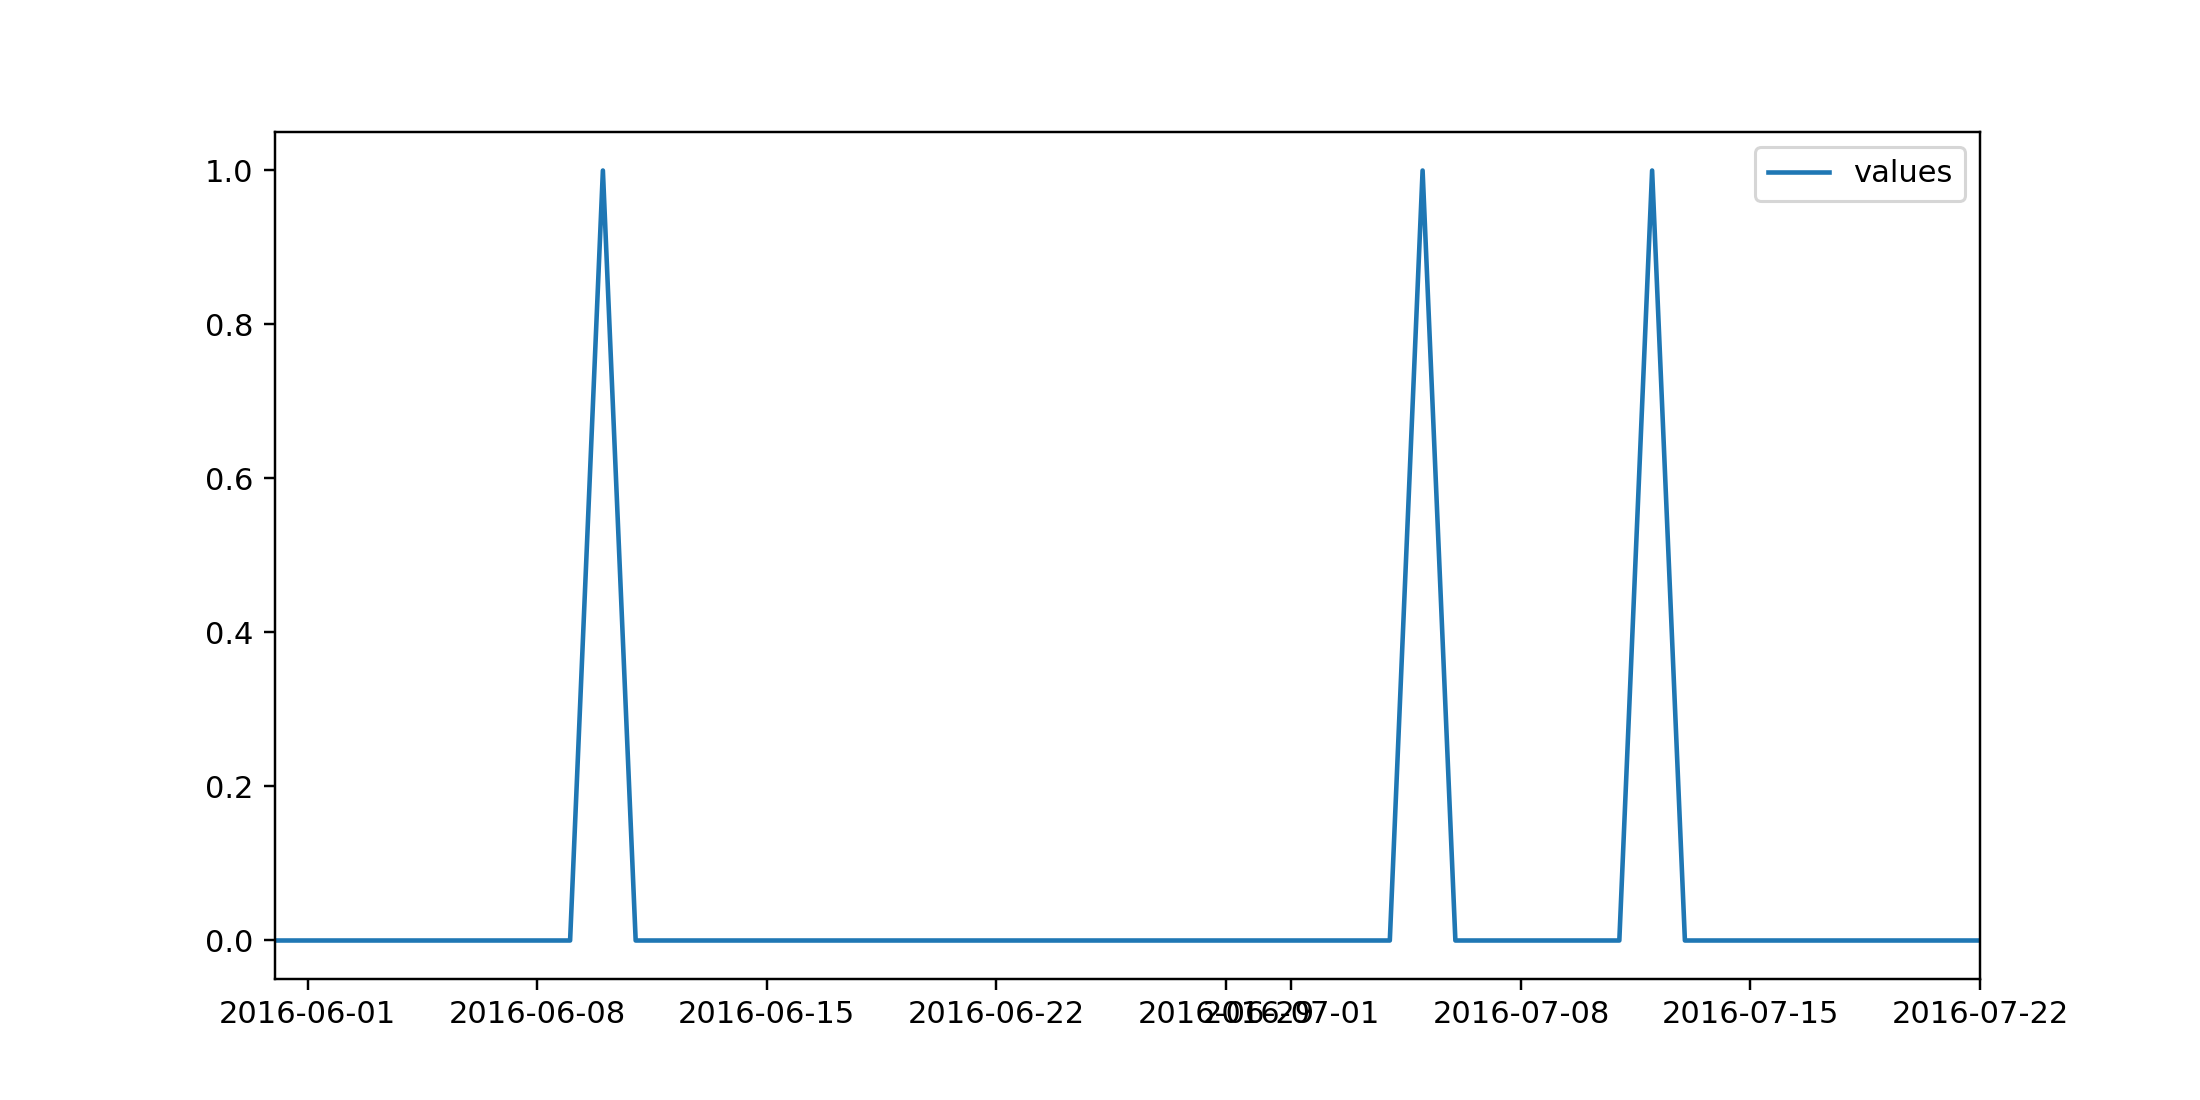

In [206]:
df = pd.DataFrame.from_dict(count_days, orient='index', columns=['values'])
df.sort_index(inplace=True)
df.plot()

In [31]:
test = pickle.load(open(f'16000_dfs/AC000W002428238_df.p', 'rb'))

In [566]:
test.index.max().date()

2018-10-06


#### Incident happened on what day of monitoring

In [761]:
df_3 = pickle.load(open(f'16000_dfs/AC000W000445713_df.p', 'rb'))
df_3 = df_3.resample('D').mean().dropna()
help_ = df_3[df_3.index < '2017-09-01 00:00:00']
help_.shape[0]+1

97

#### Save dsns that had 1st use after February 22, 2017

In [63]:
valid_dsns = []
for dsn in tqdm_notebook(list(my_list1)):
    # load df
    df = pickle.load(open(f'16000_dfs/{dsn}_df.p', 'rb'))
    
    # If 1st use is after Feb 22 2017 save dsn
    if (df.shape[0] != 0):
        if (str(df.index[0]) > '2017-02-21'):
            if dsn in list(registration_list.dsn.values):
                valid_dsns.append(dsn)
        else:
            valid_dsns.append(dsn)

In [64]:
len(valid_dsns)

15378

In [65]:
# dsns that are not empty, and are registered (or pre feb 22 2017)
# pickle.dump(valid_dsns, open("valid_dsns.p", "wb"))

In [75]:
len(set(registration_list.dsn.values))


234856